<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#load-data" data-toc-modified-id="load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load data</a></span></li><li><span><a href="#market" data-toc-modified-id="market-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>market</a></span></li><li><span><a href="#meta-algorithm" data-toc-modified-id="meta-algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>meta algorithm</a></span><ul class="toc-item"><li><span><a href="#MMMW" data-toc-modified-id="MMMW-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>MMMW</a></span></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tqdm.auto import tqdm

In [3]:
from dotenv import load_dotenv
import os
import finnhub

In [4]:
load_dotenv()  # take environment variables from .env.

True

## load data

In [5]:
API_KEY = os.getenv("API_KEY")
# print(f"using {API_KEY=} for api")

In [6]:
# Setup client
finnhub_client = finnhub.Client(api_key=API_KEY)

In [7]:
from_date = pd.to_datetime("2021-11-01")
to_date = pd.to_datetime("2021-11-05")
symbol = 'AAPL'

In [8]:
print(f"loading date {from_date=} {to_date=}")

loading date from_date=Timestamp('2021-11-01 00:00:00') to_date=Timestamp('2021-11-05 00:00:00')


In [9]:
symbols = ['AAPL', 'MSFT', 'HPQ', 'WMT']

In [10]:
results = []
for symbol in symbols:
    res = finnhub_client.stock_candles(
        symbol, 1, int(from_date.timestamp()), int(to_date.timestamp())
    )
    res['symbol'] = symbol
    results.append(res)

In [11]:
df = pd.DataFrame()
for res in results:
    df = pd.concat([df, pd.DataFrame(res)])

In [12]:
df['timestamp'] = pd.to_datetime(df['t'], unit='s')

In [13]:
df.head()

,c,h,l,o,s,t,v,symbol,timestamp
0,150.15,150.15,149.95,149.95,ok,1635753600,2289,AAPL,2021-11-01 08:00:00
1,150.00,150.00,150.00,150.00,ok,1635753660,747,AAPL,2021-11-01 08:01:00
2,149.97,150.00,149.97,149.98,ok,1635753720,900,AAPL,2021-11-01 08:02:00
3,150.00,150.03,150.00,150.00,ok,1635753780,2771,AAPL,2021-11-01 08:03:00
4,149.95,150.00,149.95,150.00,ok,1635753840,1961,AAPL,2021-11-01 08:04:00


In [14]:
df.to_csv('stocks.csv', index=False)

In [24]:
?pd.read_csv

In [28]:
df = pd.read_csv('stocks.csv')
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')

In [31]:
symbol = 'AAPL'

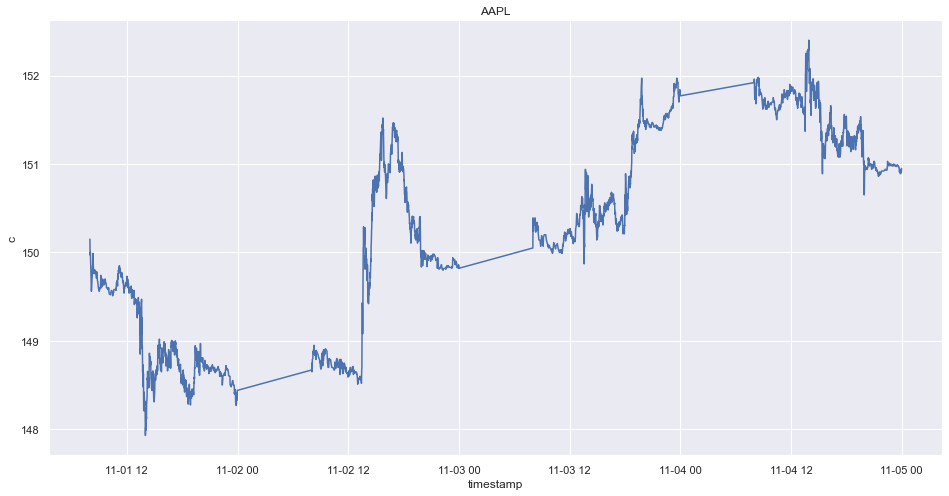

In [34]:
fig, axs = plt.subplots(figsize=(16, 8))
plt.title(symbol)
sns.lineplot(x='timestamp', y='c', data=df[df.symbol == symbol]);

## market

In [166]:
from Agent import Agent

In [167]:
p_1 = 1

In [168]:
a = Agent(b=0.5, alpha=10, a_1=p_1)

In [169]:
a.limit_order(p_current=1.5, p_next=4)

In [170]:
a.inventory

-260

In [171]:
a.cash

715.0

## meta algorithm

MMMW, MMFPL, simple Follow-The-Leader2 (FTL), and simple uniform averaging over all strategies

In [172]:
Beta = np.array([1, 2, 3, 4, 5, 10, 20, 40, 80, 100]) / 100 # in dollars, not in cents
N = len(Beta)
B = np.max(Beta)
ALPHA = 1

In [173]:
agent_to_beta = {i: b for i, b in enumerate(Beta)}
beta_to_agent = {b: i for i, b in enumerate(Beta)}

In [174]:
df['c'].diff().abs().max()

306.40000000000003

In [175]:
max_value_diff = 1  # constant for now

### MMMW

In [176]:
def update_weights(weights_prev, eta, values_prev, values_current):
    weights_new = weights_prev * np.exp(eta * (values_current - values_prev))
    weights_new = weights_new / np.sum(weights_new)  # normalization Z_t
    return weights_new

In [177]:
def get_values(agents, p):
    return np.array([a.value(p) for a in agents])

In [178]:
def eta(t):
    return np.sqrt(np.log(N) / t)

In [179]:
def market_order(X, p_current):
    # X>0 => buying
    # X<0 => selling
    cash_diff = -X * p_current
    inventory_diff = X
    return cash_diff, inventory_diff

In [180]:
symbol = 'AAPL'
df_symbol = df[df.symbol == symbol]
day = df_symbol['timestamp'].dt.date.unique()[0]
df_day = df_symbol[df_symbol['timestamp'].dt.date == day]

In [181]:
weights = np.array([1/N]*N)
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [182]:
p_1 = df_day['c'].iloc[0]

In [183]:
agents = [Agent(b=b, alpha=ALPHA, a_1=p_1) for b in Beta]

In [148]:
w = []  # weights at each step
values = []  # value at each step

G_t = 0
for t in range(1, len(df_day)-1):
    p_current = df_day.iloc[t]['c']
    p_next = df_day.iloc[t+1]['c']

    current_values = get_values(agents, p_current)
    for a in agents:
        a.limit_order(p_current, p_next)
    next_values = get_values(agents, p_next)
    
    eta_current = eta(t)
    diffs = current_values.reshape(1, -1) - current_values.reshape(-1, 1)  
    diffs = np.abs(diffs)
    G_t = max(np.max(diffs), G_t)
    
    eta_current = min(eta_current, G_t)
    
    w.append(weights)
    values.append(current_values)
    
    weights = update_weights(weights, eta_current, current_values, next_values)

In [149]:
tmp = pd.DataFrame(w).add_prefix('agent_')
tmp['T'] = tmp.index
tmp = pd.wide_to_long(tmp, ['agent_'], i='T', j='agent').reset_index().rename(columns={'agent_': 'weight'})
tmp['agent'] = tmp['agent'].astype(str)

In [150]:
tmp.head()

,T,agent,weight
0,0,0,0.049529
1,1,0,0.049529
2,2,0,0.049529
3,3,0,0.049826
4,4,0,0.050635


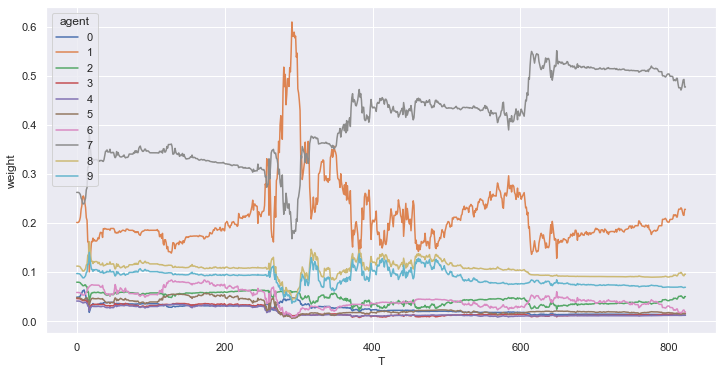

In [151]:
fig, axs= plt.subplots(figsize=(12, 6))
sns.lineplot(x='T', y='weight', hue='agent', data=tmp);